In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression

from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [3]:
df = pd.read_csv('air_dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    9357 non-null   int64  
 1   CO(GT)        9357 non-null   float64
 2   C6H6(GT)      9357 non-null   float64
 3   NOx(GT)       9357 non-null   float64
 4   PT08.S3(NOx)  9357 non-null   float64
 5   NO2(GT)       9357 non-null   float64
 6   T             9357 non-null   float64
 7   RH            9357 non-null   float64
 8   weekend       9357 non-null   int64  
 9   PT08_feat     9357 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 731.1 KB


In [5]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [6]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [7]:
class_name = 'weekend'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,CO(GT),C6H6(GT),NOx(GT),PT08.S3(NOx),NO2(GT),T,RH,PT08_feat,weekend
0,1.5,11.3,180.0,831.0,111.0,27.4,31.5,1186.50,0
1,2.0,13.0,310.0,971.0,129.0,35.0,17.3,1148.75,0
2,1.4,7.5,180.0,1114.0,119.0,24.9,28.3,1024.50,0
3,1.2,7.4,141.0,1088.0,98.0,23.2,30.5,1015.00,0
4,0.6,3.8,105.0,1254.0,89.0,22.3,33.6,883.25,0


In [9]:
attributes = ['C6H6(GT)']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

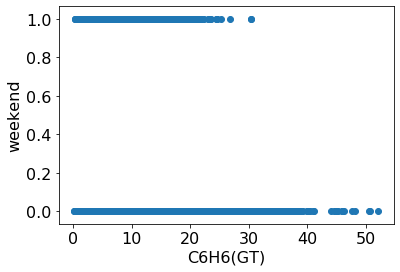

In [21]:
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [13]:
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))

Accuracy 0.7207977207977208
Precision 0.0
Recall 0.0
F1-score 0.41887417218543044
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2024
           1       0.00      0.00      0.00       784

    accuracy                           0.72      2808
   macro avg       0.36      0.50      0.42      2808
weighted avg       0.52      0.72      0.60      2808



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from scipy.special import expit

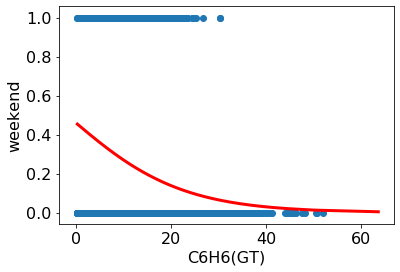

In [19]:
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test.T[0]), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [20]:
#altro attributo

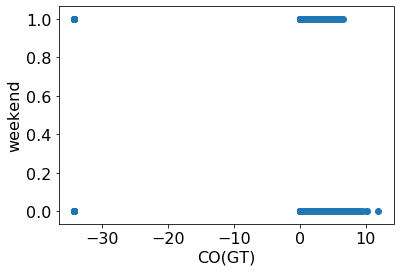

Accuracy 0.7207977207977208
Precision 0.0
Recall 0.0
F1-score 0.41887417218543044
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2024
           1       0.00      0.00      0.00       784

    accuracy                           0.72      2808
   macro avg       0.36      0.50      0.42      2808
weighted avg       0.52      0.72      0.60      2808



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


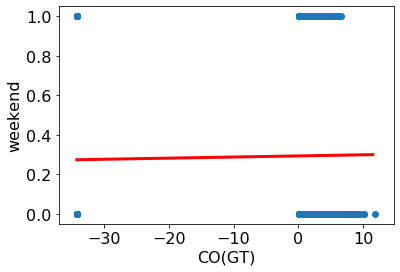

In [22]:
attributes = ['CO(GT)']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test.T[0]), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


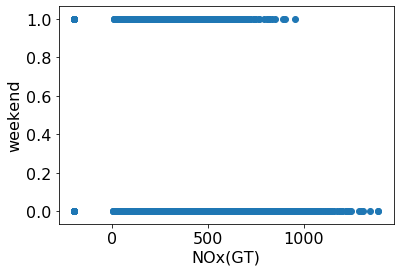

Accuracy 0.7207977207977208
Precision 0.0
Recall 0.0
F1-score 0.41887417218543044
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2024
           1       0.00      0.00      0.00       784

    accuracy                           0.72      2808
   macro avg       0.36      0.50      0.42      2808
weighted avg       0.52      0.72      0.60      2808



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


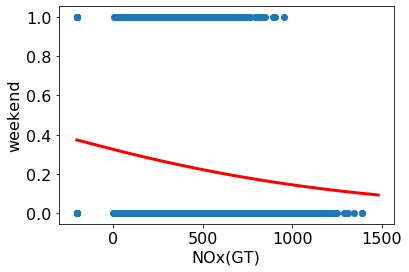

In [23]:
attributes = ['NOx(GT)']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test.T[0]), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CO(GT)        9357 non-null   float64
 1   C6H6(GT)      9357 non-null   float64
 2   NOx(GT)       9357 non-null   float64
 3   PT08.S3(NOx)  9357 non-null   float64
 4   NO2(GT)       9357 non-null   float64
 5   T             9357 non-null   float64
 6   RH            9357 non-null   float64
 7   PT08_feat     9357 non-null   float64
 8   weekend       9357 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 658.0 KB


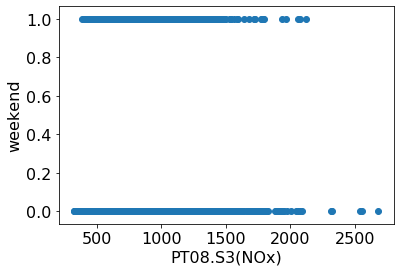

Accuracy 0.7111823361823362
Precision 0.13513513513513514
Recall 0.006377551020408163
F1-score 0.42152287642298936
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      2024
           1       0.14      0.01      0.01       784

    accuracy                           0.71      2808
   macro avg       0.43      0.50      0.42      2808
weighted avg       0.56      0.71      0.60      2808



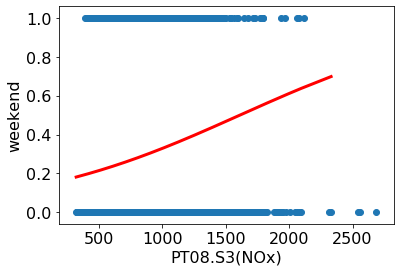

In [25]:
attributes = ['PT08.S3(NOx)']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test.T[0]), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


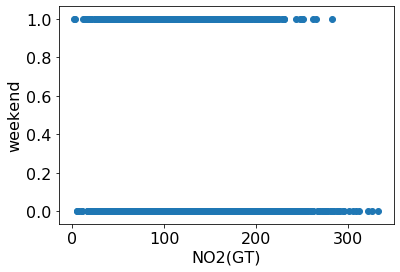

Accuracy 0.7207977207977208
Precision 0.0
Recall 0.0
F1-score 0.41887417218543044
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2024
           1       0.00      0.00      0.00       784

    accuracy                           0.72      2808
   macro avg       0.36      0.50      0.42      2808
weighted avg       0.52      0.72      0.60      2808



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


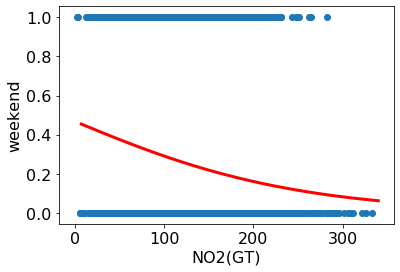

In [26]:
attributes = ['NO2(GT)']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test.T[0]), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CO(GT)        9357 non-null   float64
 1   C6H6(GT)      9357 non-null   float64
 2   NOx(GT)       9357 non-null   float64
 3   PT08.S3(NOx)  9357 non-null   float64
 4   NO2(GT)       9357 non-null   float64
 5   T             9357 non-null   float64
 6   RH            9357 non-null   float64
 7   PT08_feat     9357 non-null   float64
 8   weekend       9357 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 658.0 KB


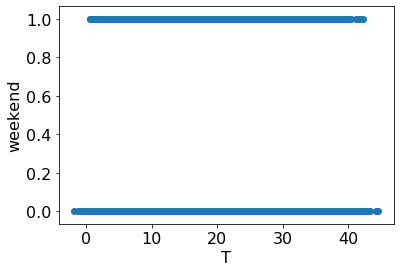

Accuracy 0.7207977207977208
Precision 0.0
Recall 0.0
F1-score 0.41887417218543044
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2024
           1       0.00      0.00      0.00       784

    accuracy                           0.72      2808
   macro avg       0.36      0.50      0.42      2808
weighted avg       0.52      0.72      0.60      2808



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


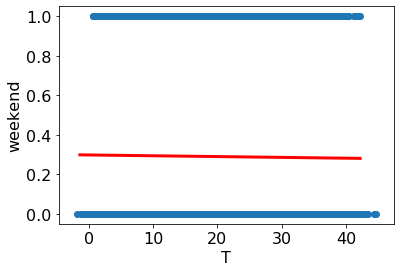

In [28]:
attributes = ['T']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test.T[0]), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


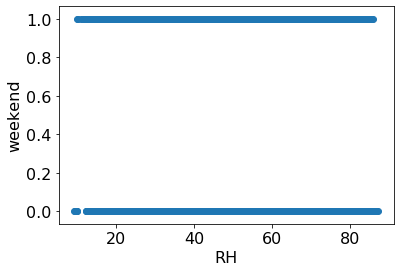

Accuracy 0.7207977207977208
Precision 0.0
Recall 0.0
F1-score 0.41887417218543044
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      2024
           1       0.00      0.00      0.00       784

    accuracy                           0.72      2808
   macro avg       0.36      0.50      0.42      2808
weighted avg       0.52      0.72      0.60      2808



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


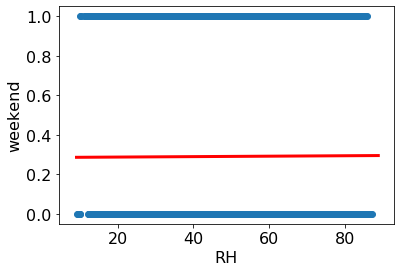

In [29]:
attributes = ['RH']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test.T[0]), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


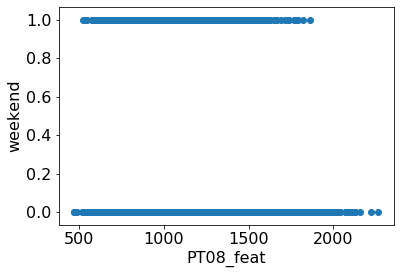

Accuracy 0.7118945868945868
Precision 0.1794871794871795
Recall 0.008928571428571428
F1-score 0.4241115600185467
              precision    recall  f1-score   support

           0       0.72      0.98      0.83      2024
           1       0.18      0.01      0.02       784

    accuracy                           0.71      2808
   macro avg       0.45      0.50      0.42      2808
weighted avg       0.57      0.71      0.60      2808



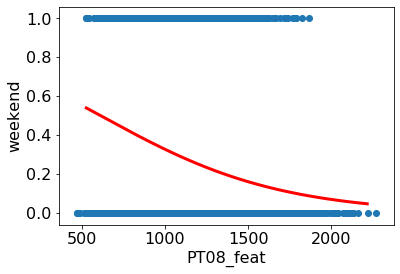

In [30]:
attributes = ['PT08_feat']
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('Precision %s' % precision_score(y_test,y_pred))
print('Recall %s' % recall_score(y_test,y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
loss = expit(sorted(X_test) * clf.coef_ + clf.intercept_).ravel()
plt.plot(sorted(X_test.T[0]), loss, color='red', linewidth=3)
plt.scatter(X_train, y_train)
plt.xlabel(attributes[0], fontsize=16)
plt.ylabel('weekend', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()
